In [45]:
import pandas as pd
import numpy as np

In [46]:
df = pd.read_csv('Star99999_raw.csv')

In [47]:
df.info()
# need to remove the nulls present in SpType - we cannot test/validate on empty star types.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  99999 non-null  int64 
 1   Vmag        99999 non-null  object
 2   Plx         99999 non-null  object
 3   e_Plx       99999 non-null  object
 4   B-V         99999 non-null  object
 5   SpType      97377 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.6+ MB


In [48]:
df.describe()

,Unnamed: 0
count,99999.000000
mean,49999.000000
std,28867.369122
min,0.000000
25%,24999.500000
50%,49999.000000
75%,74998.500000
max,99998.000000


In [49]:
#count total nulls
total_nulls = df.isnull().sum().sum()
print("\nTotal number of nulls in the dataset:", total_nulls)

# good to drop
print('Total Null percentage: ', 2622/len(df)*100)


Total number of nulls in the dataset: 2622
Total Null percentage:  2.6220262202622027


In [50]:
df.dropna(inplace=True)

#reset index
df.reset_index(inplace=True, drop=True)

In [51]:
print(df)

       Unnamed: 0   Vmag      Plx   e_Plx     B-V    SpType
0               0   9.10     3.54    1.39   0.482        F5
1               1   9.27    21.90    3.10   0.999       K3V
2               2   6.61     2.81    0.63  -0.019        B9
3               3   8.06     7.75    0.97   0.370       F0V
4               4   8.55     2.87    1.11   0.902     G8III
...           ...    ...      ...     ...     ...       ...
97372       99994   8.72     3.07    0.87   0.097        B3
97373       99995   9.25                    0.131       A1V
97374       99996   8.08     1.07    0.68   1.094        G5
97375       99997   6.98     2.97    0.76  -0.143     B1.5V
97376       99998   8.51    -1.18    1.34   1.568  K5/M0III

[97377 rows x 6 columns]


In [52]:
df.drop_duplicates(inplace=True)

In [53]:
print(df)
#no duplicates present

       Unnamed: 0   Vmag      Plx   e_Plx     B-V    SpType
0               0   9.10     3.54    1.39   0.482        F5
1               1   9.27    21.90    3.10   0.999       K3V
2               2   6.61     2.81    0.63  -0.019        B9
3               3   8.06     7.75    0.97   0.370       F0V
4               4   8.55     2.87    1.11   0.902     G8III
...           ...    ...      ...     ...     ...       ...
97372       99994   8.72     3.07    0.87   0.097        B3
97373       99995   9.25                    0.131       A1V
97374       99996   8.08     1.07    0.68   1.094        G5
97375       99997   6.98     2.97    0.76  -0.143     B1.5V
97376       99998   8.51    -1.18    1.34   1.568  K5/M0III

[97377 rows x 6 columns]


In [54]:
#change the datatypes to float.
for col in df.columns:
    if col != 'SpType':
        df[col] = pd.to_numeric(df[col], downcast="float", errors='coerce')

In [55]:
#look at e_plx
print('Before dropping outliers...', df['e_Plx'].describe())

# need to drop any parallex margin of errors that are statistically significant. This will be 3 STD's away from median.
# we chose median because astronomoical values can vary so greatly - median tends to be the better
# identifier of for the standard of the dataset without any outliers skewing the data.
mean = df['e_Plx'].mean()
std = df['e_Plx'].std()

threshold = mean + (3 * std)

df = df[df['e_Plx'] < threshold]

print('After dropping outliers...', df['e_Plx'].describe())

Before dropping outliers... count    97268.000000
mean         1.277213
std          1.210870
min          0.380000
25%          0.870000
50%          1.090000
75%          1.370000
max         69.070000
Name: e_Plx, dtype: float64
After dropping outliers... count    96311.000000
mean         1.194724
std          0.535176
min          0.380000
25%          0.870000
50%          1.080000
75%          1.355000
max          4.900000
Name: e_Plx, dtype: float64


In [56]:
# add abs mag
df["Abs_Mag"] = df["Vmag"] + 5 * (np.log10(abs(df["Plx"]))+1)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-56-811d3e918dc7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Abs_Mag"] = df["Vmag"] + 5 * (np.log10(abs(df["Plx"]))+1)


In [57]:
## divide by zero error - filter out any parallax that = 0
df = df[df['Plx'] != 0]

In [58]:
df["Abs_Mag"] = df["Vmag"] + 5 * (np.log10(abs(df["Plx"]))+1)

In [59]:

# Create the classification column
def categorize_star_type(sp_type):
    if "V" in sp_type:
        if "VII" in sp_type:
            return 0  # Dwarfs are VII
        else:
            return 1  # Giants are V, IV, and VI
    elif "I" in sp_type:
        return 0  # Dwarfs are I, II, III
    else:
        return 3  # Other Class

# Apply the function to the 'SpType' column to create the 'Target' column
df['Target'] = df['SpType'].apply(categorize_star_type)

In [60]:
print(df)

       Unnamed: 0  Vmag    Plx  e_Plx    B-V    SpType    Abs_Mag  Target
0             0.0  9.10   3.54   1.39  0.482        F5  16.845016       3
1             1.0  9.27  21.90   3.10  0.999       K3V  20.972221       1
2             2.0  6.61   2.81   0.63 -0.019        B9  13.853533       3
3             3.0  8.06   7.75   0.97  0.370       F0V  17.506508       1
4             4.0  8.55   2.87   1.11  0.902     G8III  15.839410       0
...           ...   ...    ...    ...    ...       ...        ...     ...
97371     99993.0  7.92   3.93   1.24  0.133     Am...  15.891963       3
97372     99994.0  8.72   3.07   0.87  0.097        B3  16.155693       3
97374     99996.0  8.08   1.07   0.68  1.094        G5  13.226919       3
97375     99997.0  6.98   2.97   0.76 -0.143     B1.5V  14.343782       1
97376     99998.0  8.51  -1.18   1.34  1.568  K5/M0III  13.869411       0

[96272 rows x 8 columns]


In [61]:
#drop unnamed column
df = df.drop(columns=['Unnamed: 0'])


In [62]:
print(df)

       Vmag    Plx  e_Plx    B-V    SpType    Abs_Mag  Target
0      9.10   3.54   1.39  0.482        F5  16.845016       3
1      9.27  21.90   3.10  0.999       K3V  20.972221       1
2      6.61   2.81   0.63 -0.019        B9  13.853533       3
3      8.06   7.75   0.97  0.370       F0V  17.506508       1
4      8.55   2.87   1.11  0.902     G8III  15.839410       0
...     ...    ...    ...    ...       ...        ...     ...
97371  7.92   3.93   1.24  0.133     Am...  15.891963       3
97372  8.72   3.07   0.87  0.097        B3  16.155693       3
97374  8.08   1.07   0.68  1.094        G5  13.226919       3
97375  6.98   2.97   0.76 -0.143     B1.5V  14.343782       1
97376  8.51  -1.18   1.34  1.568  K5/M0III  13.869411       0

[96272 rows x 7 columns]


In [63]:
from sklearn.utils import resample
from sklearn.utils import shuffle

#try to classify on the 3 classes: 0 Dwarf, 1 Giant, 3 other
value_counts = df['Target'].value_counts()
print(value_counts)

giants = df[df['Target'] == 1]
others = df[df['Target'] == 3]
dwarfs = df[df['Target']== 0]

#significantly more other stars, then more Giants, not as many dwarfs. We need to rebalance dataset.
resamp_giants = resample(giants,
                                 replace=False,
                                 n_samples=dwarfs.shape[0],
                                 random_state=1)
resamp_others = resample(others,
                                 replace=False,
                                 n_samples=dwarfs.shape[0],
                                 random_state=1)

df = pd.concat([resamp_others, resamp_giants, dwarfs])
df.reset_index(inplace=True, drop=True)
df = shuffle(df)
print(df)
print(df['Target'].value_counts())

Target
3    48907
1    27591
0    19774
Name: count, dtype: int64
       Vmag        Plx  e_Plx    B-V    SpType    Abs_Mag  Target
49961  6.51  10.670000   0.76  0.311     A7III  16.650822       0
44926  7.56   1.930000   0.87  1.640     M2III  13.987786       0
37103  6.77  23.969999   0.97  0.468       F5V  18.668341       1
9082   6.80   2.190000   0.87  0.700      M...  13.502220       3
29907  7.68   6.110000   0.60  0.152    B6IV/V  16.610207       1
...     ...        ...    ...    ...       ...        ...     ...
53702  6.93   1.630000   0.77  1.028  G6II+...  12.990938       0
41722  7.99   1.850000   0.80  1.437  K2/K3III  14.325859       0
37489  7.86   2.870000   1.19 -0.008       B8V  15.149410       1
51031  6.23   1.730000   0.55  1.237      G3Ib  12.420231       0
21148  6.70   3.450000   0.83 -0.059      B9IV  14.389095       1

[59322 rows x 7 columns]
Target
0    19774
1    19774
3    19774
Name: count, dtype: int64


In [64]:
df.dropna(inplace=True)

#reset index
df.reset_index(inplace=True, drop=True)

In [65]:
#attempt to classify the 3 classes

# Split data into Feature and Label data - independent and dependent variables.
X = df[['Vmag', 'Plx', 'B-V', 'e_Plx', 'B-V', 'Abs_Mag']]
X = X.values
Y = df[['Target']]
Y = Y.values
Y = Y.flatten().astype('int')

In [66]:
# use label encoding since we are turning a categorical variable into numerical.
from sklearn.preprocessing import LabelEncoder
encoded_x = LabelEncoder()
X[:,4]=encoded_x.fit_transform(X[:,4])
print(X)

[[ 6.5100002e+00  1.0670000e+01  3.1099999e-01  7.5999999e-01
   5.4900000e+02  1.6650822e+01]
 [ 7.5599999e+00  1.9299999e+00  1.6400000e+00  8.7000000e-01
   1.8780000e+03  1.3987786e+01]
 [ 6.7700000e+00  2.3969999e+01  4.6799999e-01  9.7000003e-01
   7.0600000e+02  1.8668341e+01]
 ...
 [ 7.8600001e+00  2.8699999e+00 -8.0000004e-03  1.1900001e+00
   2.3000000e+02  1.5149410e+01]
 [ 6.2300000e+00  1.7300000e+00  1.2370000e+00  5.5000001e-01
   1.4750000e+03  1.2420231e+01]
 [ 6.6999998e+00  3.4500000e+00 -5.9000000e-02  8.2999998e-01
   1.7900000e+02  1.4389095e+01]]


In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

#Split into test and training set.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)
#standard scale for KNeighbors - this algorithm is sensitive to scaling.
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [77]:
#try random forest - get accuracy
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score


random_forest = RandomForestClassifier(max_depth = 5, n_estimators=100, random_state=50)
random_forest.fit(X_train, y_train)
preds = random_forest.predict(X_test)
r_acc = accuracy_score(y_test, preds)
r_f1 = f1_score(y_test, preds, average=None) # for non binary classification
r_prec = precision_score(y_test, preds, average='micro') # Calculate metrics globally
r_rec = recall_score(y_test, preds, average='micro') # Calculate metrics globally
print(r_acc)
print(r_f1)
print(r_prec)
print(r_rec)
#

decision_tree = DecisionTreeClassifier(max_depth = 5, min_samples_split=2, splitter='best')
decision_tree.fit(X_train, y_train)
preds = decision_tree.predict(X_test)
d_acc = accuracy_score(y_test, preds)
d_f1 = f1_score(y_test, preds, average=None) # for non binary classification
d_prec = precision_score(y_test, preds, average='micro') # Calculate metrics globally
d_rec = recall_score(y_test, preds, average='micro') # Calculate metrics globally
print(d_acc)
print(d_f1)
print(d_prec)
print(d_rec)

#DropNan values from X
k_neighbors = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='uniform')
k_neighbors.fit(X_train_scaled, y_train)
preds = k_neighbors.predict(X_test_scaled)
k_acc = accuracy_score(y_test, preds)
k_f1 = f1_score(y_test, preds, average=None) # for non binary classification
k_prec = precision_score(y_test, preds, average='micro') # Calculate metrics globally
k_rec = recall_score(y_test, preds, average='micro') # Calculate metrics globally
print(k_acc)
print(k_f1)
print(k_prec)
print(k_rec)

0.6196792312377343
[0.7491731  0.67426083 0.31347497]
0.6196792312377343
0.6196792312377343
0.6087162482235907
[0.74213042 0.67523402 0.21327419]
0.6087162482235907
0.6087162482235907
0.5777221357515058
[0.69637831 0.60485909 0.39832675]
0.5777221357515058
0.5777221357515058


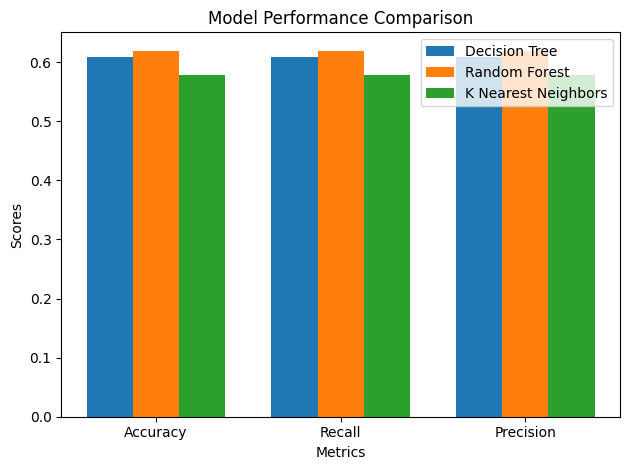

In [78]:
#plot
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their metrics
models = ['Decision Tree', 'Random Forest', 'K Nearest Neighbors']
metrics = ['Accuracy', 'Recall', 'Precision']

# Example metric values for each model
model_1_scores = [d_acc, d_rec, d_prec]
model_2_scores = [r_acc, r_rec, r_prec]
model_3_scores = [k_acc, k_rec, k_prec]

# Create a bar plot
x = np.arange(len(metrics))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
bars1 = ax.bar(x - width, model_1_scores, width, label='Decision Tree')
bars2 = ax.bar(x, model_2_scores, width, label='Random Forest')
bars3 = ax.bar(x + width, model_3_scores, width, label='K Nearest Neighbors')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()

plt.show()


In [73]:
#Accuracy and performance metrics are not the best. this is likely due to trying to categorize
#stars also under an 'other' category as well.

#Try a grid search, retrain to see if the accuracy improves.
#DecisionTree
from sklearn.model_selection import GridSearchCV

#perform a grid search for each algorithm to find the optimal hyper paramters
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid={
    'max_depth': list(range(1, 15, 1)),
    'min_samples_split': list(range(2, 20, 2)),
    'splitter': ["best", "random"]
}, cv=5, verbose=1, error_score='raise')

        # Fit GridSearchCV with the training data.
grid_search.fit(X_train, y_train)

        # Print the best parameters and best score found by GridSearchCV.
print(f"Best parameters found for Decision Tree: {grid_search.best_params_}")
#RandomForest
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid={
    'n_estimators': list(range(1, 100, 50)),
    'max_depth': list(range(1, 15, 1)),
    'random_state': list(range(0, 100, 25))
}, cv=5, verbose=1, error_score='raise')

# Fit GridSearchCV with the training data.
grid_search.fit(X_train, y_train)

        # Print the best parameters and best score found by GridSearchCV.
print(f"Best parameters found for RandomForest Tree: {grid_search.best_params_}")
#KNearest
grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={
    'n_neighbors': list(range(1, 15, 1)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}, cv=5, verbose=1, error_score='raise')

        # Fit GridSearchCV with the training data.
grid_search.fit(X_train, y_train)

        # Print the best parameters and best score found by GridSearchCV.
print(f"Best parameters found for KNeighbors: {grid_search.best_params_}")


Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Best parameters found for Decision Tree: {'max_depth': 9, 'min_samples_split': 16, 'splitter': 'best'}
Fitting 5 folds for each of 112 candidates, totalling 560 fits
Best parameters found for RandomForest Tree: {'max_depth': 8, 'n_estimators': 51, 'random_state': 75}
Fitting 5 folds for each of 56 candidates, totalling 280 fits
Best parameters found for KNeighbors: {'metric': 'manhattan', 'n_neighbors': 14, 'weights': 'uniform'}


In [80]:
# Try to refit with the optimal hyperparameters
#try random forest - get accuracy
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score


random_forest = RandomForestClassifier(max_depth = 9, n_estimators=51, random_state=75)
random_forest.fit(X_train, y_train)
preds = random_forest.predict(X_test)
r_acc = accuracy_score(y_test, preds)
r_f1 = f1_score(y_test, preds, average=None) # for non binary classification
r_prec = precision_score(y_test, preds, average='micro') # Calculate metrics globally
r_rec = recall_score(y_test, preds, average='micro') # Calculate metrics globally
print(r_acc)
print(r_f1)
print(r_prec)
print(r_rec)

decision_tree = DecisionTreeClassifier(max_depth = 9, min_samples_split=16, splitter='best')
decision_tree.fit(X_train, y_train)
preds = decision_tree.predict(X_test)
d_acc = accuracy_score(y_test, preds)
d_f1 = f1_score(y_test, preds, average=None) # for non binary classification
d_prec = precision_score(y_test, preds, average='micro') # Calculate metrics globally
d_rec = recall_score(y_test, preds, average='micro') # Calculate metrics globally
print(d_acc)
print(d_f1)
print(d_prec)
print(d_rec)

#DropNan values from X
k_neighbors = KNeighborsClassifier(n_neighbors=14, metric='manhattan', weights='uniform')
k_neighbors.fit(X_train_scaled, y_train)
preds = k_neighbors.predict(X_test_scaled)
k_acc = accuracy_score(y_test, preds)
k_f1 = f1_score(y_test, preds, average=None) # for non binary classification
k_prec = precision_score(y_test, preds, average='micro') # Calculate metrics globally
k_rec = recall_score(y_test, preds, average='micro') # Calculate metrics globally
print(k_acc)
print(k_f1)
print(k_prec)
print(k_rec)

0.6275292684577384
[0.75041111 0.66684597 0.38824792]
0.6275292684577384
0.6275292684577384
0.6183257765446302
[0.74459035 0.65660309 0.38530676]
0.6183257765446302
0.6183257765446302
0.6093253028354876
[0.7343102  0.64158305 0.39476005]
0.6093253028354876
0.6093253028354876


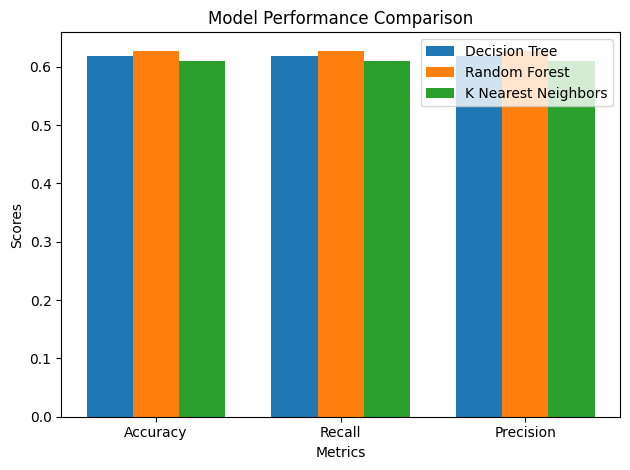

In [81]:
#plot
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their metrics
models = ['Decision Tree', 'Random Forest', 'K Nearest Neighbors']
metrics = ['Accuracy', 'Recall', 'Precision']

# Example metric values for each model
model_1_scores = [d_acc, d_rec, d_prec]
model_2_scores = [r_acc, r_rec, r_prec]
model_3_scores = [k_acc, k_rec, k_prec]

# Create a bar plot
x = np.arange(len(metrics))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
bars1 = ax.bar(x - width, model_1_scores, width, label='Decision Tree')
bars2 = ax.bar(x, model_2_scores, width, label='Random Forest')
bars3 = ax.bar(x + width, model_3_scores, width, label='K Nearest Neighbors')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()

plt.show()


In [ ]:
#still below goal of 80% accuracy...

In [82]:
# Try a 2 star classification - Dwarf and Giant. the 3 classes may be too much for these
# classification models. there is no distinct pattern for the 3rd class of 'other'. Lets
# remove and see if we improve accuracy
df = df[(df['Target'] == 1) | (df['Target'] == 0)]


In [83]:
X = df[['Vmag', 'Plx', 'B-V', 'e_Plx', 'B-V', 'Abs_Mag']]
X = X.values
Y = df[['Target']]
Y = Y.values
Y = Y.flatten().astype('int')

In [84]:
#Split into test and training set.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)
#standard scale for KNeighbors - this algorithm is sensitive to scaling.
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

0.8849817592217268
0.8860098423219844
0.860011698186781
0.9136288318144159


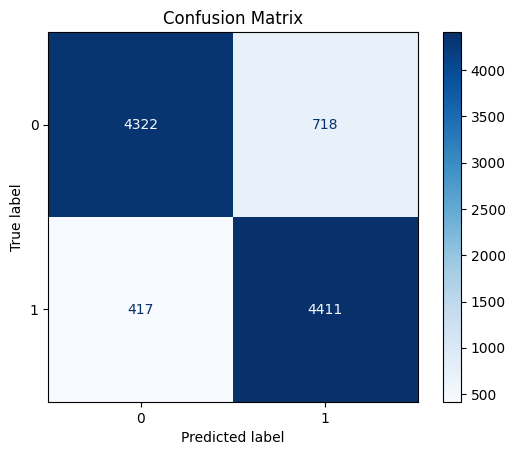

0.6183257765446302
0.8807266194230962
0.8499325756116355
0.9138359569179785
0.8715038508309688
0.8701085843064945
0.8607620591811918
0.8796603148301574


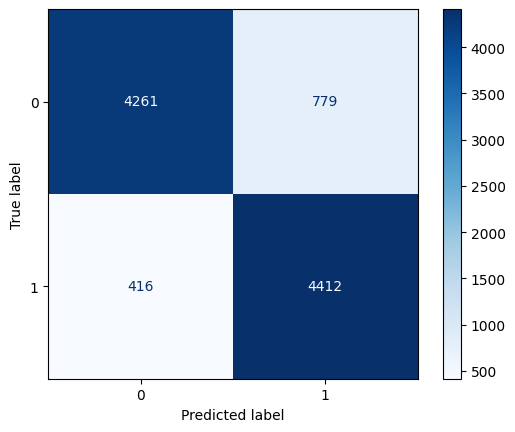

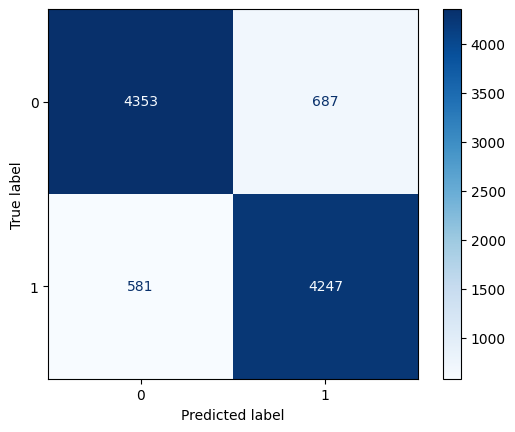

In [85]:
#try random forest - get accuracy
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


random_forest = RandomForestClassifier(max_depth = 5, n_estimators=100, random_state=50)
random_forest.fit(X_train, y_train)
preds = random_forest.predict(X_test)
r_acc = accuracy_score(y_test, preds)
r_f1 = f1_score(y_test, preds, average='binary') # Calculate metrics globally
r_prec = precision_score(y_test, preds, average='binary') # Calculate metrics globally
r_rec = recall_score(y_test, preds, average='binary') # Calculate metrics globally
print(r_acc)
print(r_f1)
print(r_prec)
print(r_rec)

cm = confusion_matrix(y_test, preds)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

# Customize the plot
plt.title('Confusion Matrix')
plt.show()

decision_tree = DecisionTreeClassifier(max_depth = 5, min_samples_split=2, splitter='best')
decision_tree.fit(X_train, y_train)
preds = decision_tree.predict(X_test)
d_f1 = f1_score(y_test, preds, average='binary') # binary
d_prec = precision_score(y_test, preds, average='binary') # binary
d_rec = recall_score(y_test, preds, average='binary') # binary
print(d_acc)
print(d_f1)
print(d_prec)
print(d_rec)

cm = confusion_matrix(y_test, preds)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

#DropNan values from X
k_neighbors = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='uniform')
k_neighbors.fit(X_train_scaled, y_train)
preds = k_neighbors.predict(X_test_scaled)
k_acc = accuracy_score(y_test, preds)
k_f1 = f1_score(y_test, preds, average='binary') # binary
k_prec = precision_score(y_test, preds, average='binary') # binary
k_rec = recall_score(y_test, preds, average='binary') # binary
print(k_acc)
print(k_f1)
print(k_prec)
print(k_rec)

cm = confusion_matrix(y_test, preds)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

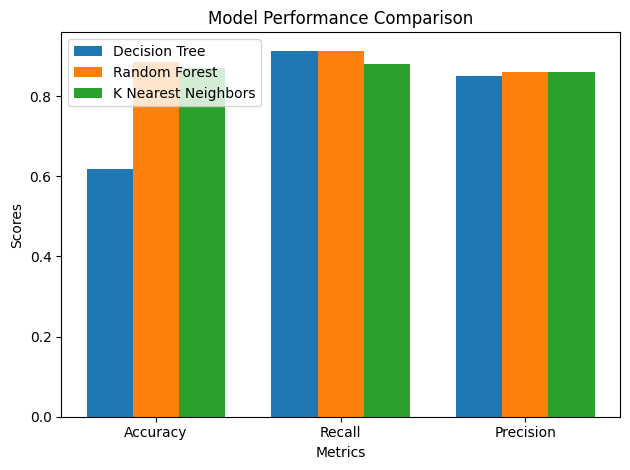

In [86]:
#plot
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their metrics
models = ['Decision Tree', 'Random Forest', 'K Nearest Neighbors']
metrics = ['Accuracy', 'Recall', 'Precision']

# Example metric values for each model
model_1_scores = [d_acc, d_rec, d_prec]
model_2_scores = [r_acc, r_rec, r_prec]
model_3_scores = [k_acc, k_rec, k_prec]

# Create a bar plot
x = np.arange(len(metrics))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
bars1 = ax.bar(x - width, model_1_scores, width, label='Decision Tree')
bars2 = ax.bar(x, model_2_scores, width, label='Random Forest')
bars3 = ax.bar(x + width, model_3_scores, width, label='K Nearest Neighbors')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()

plt.show()


In [87]:
#MUCH higher accuracy.. (not necessarily for decision tree..) and achieving goal!

#Introducing a class for 'Other' with varying features with no distinct pattern is confirmed
# to be reducing accuracy for the model. Perform a grid search for this new binary classification.


#Accuracy and performance metrics are not the best. this is likely due to trying to categorize
#stars also under an 'other' category as well.

#Try a grid search, retrain to see if the accuracy improves.
#DecisionTree
from sklearn.model_selection import GridSearchCV

#perform a grid search for each algorithm to find the optimal hyper paramters
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid={
    'max_depth': list(range(1, 15, 1)),
    'min_samples_split': list(range(2, 20, 2)),
    'splitter': ["best", "random"]
}, cv=5, verbose=1, error_score='raise')

        # Fit GridSearchCV with the training data.
grid_search.fit(X_train, y_train)

        # Print the best parameters and best score found by GridSearchCV.
print(f"Best parameters found for Decision Tree: {grid_search.best_params_}")
#RandomForest
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid={
    'n_estimators': list(range(1, 100, 50)),
    'max_depth': list(range(1, 15, 1)),
    'random_state': list(range(0, 100, 25))
}, cv=5, verbose=1, error_score='raise')

# Fit GridSearchCV with the training data.
grid_search.fit(X_train, y_train)

        # Print the best parameters and best score found by GridSearchCV.
print(f"Best parameters found for RandomForest Tree: {grid_search.best_params_}")
#KNearest
grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={
    'n_neighbors': list(range(1, 15, 1)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}, cv=5, verbose=1, error_score='raise')

        # Fit GridSearchCV with the training data.
grid_search.fit(X_train, y_train)

        # Print the best parameters and best score found by GridSearchCV.
print(f"Best parameters found for KNeighbors: {grid_search.best_params_}")


Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Best parameters found for Decision Tree: {'max_depth': 7, 'min_samples_split': 18, 'splitter': 'best'}
Fitting 5 folds for each of 112 candidates, totalling 560 fits
Best parameters found for RandomForest Tree: {'max_depth': 8, 'n_estimators': 51, 'random_state': 50}
Fitting 5 folds for each of 56 candidates, totalling 280 fits
Best parameters found for KNeighbors: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}


0.8849817592217268
0.8857574232511324
0.8615625611905228
0.9113504556752279


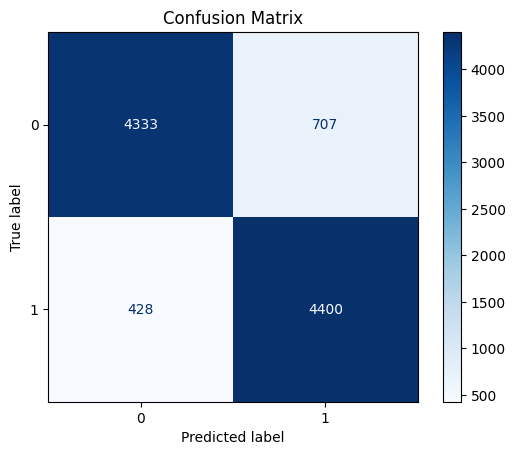

0.876773408998784
0.8775674587192912
0.8538401253918495
0.9026512013256006
0.880624239967572
0.8798939641109298
0.8664658634538153
0.8937448218724109


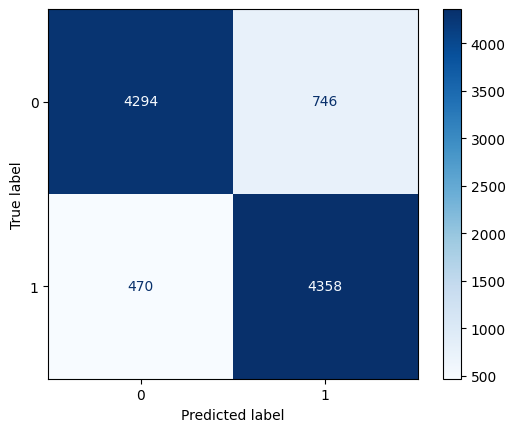

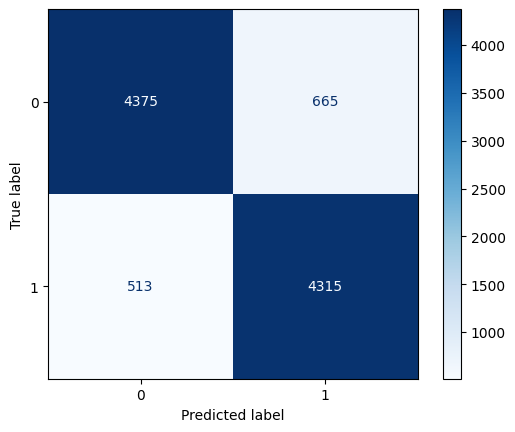

In [90]:
#try random forest - get accuracy
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


random_forest = RandomForestClassifier(max_depth = 8, n_estimators=51, random_state=50)
random_forest.fit(X_train, y_train)
preds = random_forest.predict(X_test)
r_acc = accuracy_score(y_test, preds)
r_f1 = f1_score(y_test, preds, average='binary') # Calculate metrics globally
r_prec = precision_score(y_test, preds, average='binary') # Calculate metrics globally
r_rec = recall_score(y_test, preds, average='binary') # Calculate metrics globally
print(r_acc)
print(r_f1)
print(r_prec)
print(r_rec)

cm = confusion_matrix(y_test, preds)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

# Customize the plot
plt.title('Confusion Matrix')
plt.show()

decision_tree = DecisionTreeClassifier(max_depth = 7, min_samples_split=18, splitter='best')
decision_tree.fit(X_train, y_train)
preds = decision_tree.predict(X_test)
d_acc = accuracy_score(y_test, preds)
d_f1 = f1_score(y_test, preds, average='binary') # binary
d_prec = precision_score(y_test, preds, average='binary') # binary
d_rec = recall_score(y_test, preds, average='binary') # binary
print(d_acc)
print(d_f1)
print(d_prec)
print(d_rec)

cm = confusion_matrix(y_test, preds)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

#DropNan values from X
k_neighbors = KNeighborsClassifier(n_neighbors=11, metric='manhattan', weights='uniform')
k_neighbors.fit(X_train_scaled, y_train)
preds = k_neighbors.predict(X_test_scaled)
k_acc = accuracy_score(y_test, preds)
k_f1 = f1_score(y_test, preds, average='binary') # binary
k_prec = precision_score(y_test, preds, average='binary') # binary
k_rec = recall_score(y_test, preds, average='binary') # binary
print(k_acc)
print(k_f1)
print(k_prec)
print(k_rec)

cm = confusion_matrix(y_test, preds)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

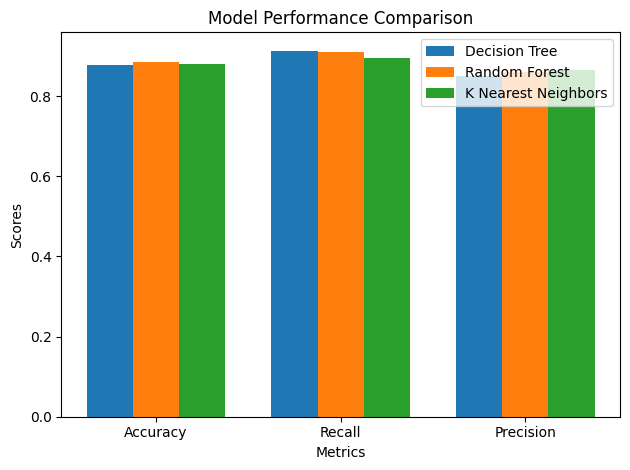

In [89]:
#plot
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their metrics
models = ['Decision Tree', 'Random Forest', 'K Nearest Neighbors']
metrics = ['Accuracy', 'Recall', 'Precision']

# Example metric values for each model
model_1_scores = [d_acc, d_rec, d_prec]
model_2_scores = [r_acc, r_rec, r_prec]
model_3_scores = [k_acc, k_rec, k_prec]

# Create a bar plot
x = np.arange(len(metrics))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
bars1 = ax.bar(x - width, model_1_scores, width, label='Decision Tree')
bars2 = ax.bar(x, model_2_scores, width, label='Random Forest')
bars3 = ax.bar(x + width, model_3_scores, width, label='K Nearest Neighbors')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()

plt.show()
